# Box Atlas Value Function Intervals

I want to determine if I can collect reasonable intervals for the box atlas value function without spending oodles of time solving MIQPs. 

To do that, I'm going to sweep along a single parameter and then plot the resulting intervals with some sort of early-termination criterion. 

In [1]:
using Revise

In [59]:
using MeshCat
using MeshCatMechanisms
using RigidBodyDynamics
using JuMP
using Gurobi
using JLD2
using Flux
using MLDataPattern
using Plots; gr()

Plots.GRBackend()

In [3]:
import LCPSim
import BoxValkyries

INFO: Recompiling stale cache file /home/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/BoxValkyries.ji for module BoxValkyries.


In [4]:
robot = BoxValkyries.BoxValkyrie()
mvis = MechanismVisualizer(robot)
IJuliaCell(mvis)

Listening on 127.0.0.1:7000...
zmq_url=tcp://127.0.0.1:6000
web_url=http://127.0.0.1:7000/static/


MeshCat.IJuliaCell(MeshCat.ViewerWindow(ZMQ.Context(Ptr{Void} @0x0000000006566840, ZMQ.Socket[ZMQ.Socket(Ptr{Void} @0x000000000659d290, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000006584070, 55, (1, 0), Condition(Any[]), (false, false), 0))]), ZMQ.Socket(Ptr{Void} @0x000000000659d290, Base.Filesystem._FDWatcher(Ptr{Void} @0x0000000006584070, 55, (1, 0), Condition(Any[]), (false, false), 0)), "http://127.0.0.1:7000/static/", "tcp://127.0.0.1:6000", MeshCat.ZMQServer.ZMQWebSocketBridge(ip"127.0.0.1", Set{WebSockets.WebSocket}(), MeshCat.SceneTrees.SceneNode(Nullable{Array{UInt8,1}}(), Nullable{Array{UInt8,1}}(), Dict("meshcat"=>MeshCat.SceneTrees.SceneNode(#NULL, #NULL, Dict("robot"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x72, 0x6f, 0x62, 0x6f, 0x74], Dict("world"=>MeshCat.SceneTrees.SceneNode(#NULL, #NULL, Dict("dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("base"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x64, 0x75, 0x6d, 0x6d, 0x79, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict("core"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x62, 0x61, 0x73, 0x65, 0x2f, 0x63, 0x6f, 0x72, 0x65], Dict("rh_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x2f, 0x72, 0x68, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("after_core_to_rh_rotation"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x5f, 0x72, 0x6f, 0x74, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict("geometry_2"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String,MeshCat.SceneTrees.SceneNode}()))),"rh"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x2f, 0x72, 0x68], Dict("after_core_to_rh_extension"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x65, 0x78, 0x74, 0x65, 0x6e, 0x73, 0x69, 0x6f, 0x6e], Dict("geometry_3"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], Dict{String,MeshCat.SceneTrees.SceneNode}()))))))),"rf_dummy"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x2f, 0x72, 0x66, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79], Dict("after_core_to_rf_rotation"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x5f, 0x72, 0x6f, 0x74, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict("geometry_6"=>MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x36], Dict{String,MeshCat.SceneTrees.SceneNode}()))),"rf"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x5f, 0x64, 0x75, 0x6d, 0x6d, 0x79, 0x2f, 0x72, 0x66], Dict("after_core_to_rf_extension"=>MeshCat.SceneTrees.SceneNode(#NULL, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x5f, 0x65, 0x78, 0x74, 0x65, 

In [43]:
xstar = BoxValkyries.nominal_state(robot)
mpc_params = LearningMPC.MPCParams(
    Δt=0.05,
    horizon=10,
    mip_solver=GurobiSolver(Gurobi.Env(), OutputFlag=0, 
        TimeLimit=5,
        FeasibilityTol=1e-3),
    lcp_solver=GurobiSolver(Gurobi.Env(), OutputFlag=0))

Q, R = BoxValkyries.default_costs(robot)
feet = findbody.(robot.mechanism, ["lf", "rf"])
lqrsol = LearningMPC.LQRSolution(xstar, Q, R, mpc_params.Δt, Point3D.(default_frame.(feet), 0., 0., 0.))
# lqrsol.S .= 1 ./ mpc_params.Δt .* Q

mpc_controller = LearningMPC.MPCController(robot.mechanism, 
    robot.environment, mpc_params, lqrsol, 
    [lqrsol]);

sample_sink = LearningMPC.MPCSampleSink{Float64}(true)
playback_sink = LearningMPC.PlaybackSink(mvis, mpc_params.Δt)

mpc_controller.callback = LearningMPC.call_each(
    sample_sink,
    playback_sink,
)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::#35) (generic function with 1 method)

In [44]:
x0 = BoxValkyries.nominal_state(robot)

MechanismState{Float64, Float64, Float64, …}(…)

In [45]:
mpc_controller(x0)

10-element Array{Float64,1}:
 0.0        
 0.0        
 0.24525    
 0.24525    
 2.22045e-16
 2.22045e-16
 0.0        
 0.0        
 5.3955     
 5.3955     

In [46]:
empty!(sample_sink)
for v_x in linspace(-6, 6, 31)
    x0 = BoxValkyries.nominal_state(robot)
    set_velocity!(x0, findjoint(robot.mechanism, "base_x"), v_x)
    mpc_controller(x0)
end

In [47]:
jldopen("results.jld2", "w") do file
    file["samples"] = sample_sink.samples
    file["lqrsol"] = lqrsol
    file["mpc_params"] = Dict(
            "Δt" => mpc_params.Δt,
            "horizon" => mpc_params.horizon,
        )
end

Dict{String,Any} with 2 entries:
  "horizon" => 10
  "Δt"      => 0.05

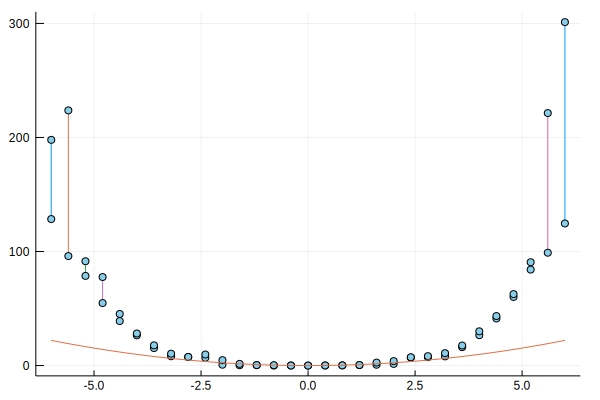

In [50]:
plt = plot(legend=nothing)
for sample in sample_sink.samples
    plot!(plt, [sample.state[11], sample.state[11]], 
            [sample.mip.objective_bound, sample.mip.objective_value],
        marker=:circle,
        markercolor="skyblue"
        )
end

x0 = BoxValkyries.nominal_state(robot)
plot!(plt, linspace(-6, 6, 101), function (v_x)
    set_velocity!(x0, findjoint(robot.mechanism, "base_x"), v_x)
    x = Vector(x0)
    (x - lqrsol.x0)' * lqrsol.S * (x - lqrsol.x0)
end
    )
# ylims!(plt, (-10, 300))
plt

In [51]:
savefig("value-function-intervals.png")
savefig("value-function-intervals.pdf")

Ok, these results seem sane so far. The MIQP cost closely tracks the LQR cost near the origin, but then increases as we get farther away. In addition, the bounds widen as the problems get harder to solve, which is exactly what I'd expect. There's even an asymmetry because the presence of the wall in the -x direction makes solving problems with -x velocity easier. 

In [61]:
function create_net()
    net = Chain(
        Dense(1, 16, elu),
        Dense(16, 16, elu),
        Dense(16, 1)
    )
    loss = (x, lb, ub) -> begin
        y = net(x)
        sum(ifelse.(y .< lb, lb .- y, ifelse.(y .> ub, y .- ub, 0 .* y)))
    end
    net, loss
end

features(s::LearningMPC.Sample) = (s.state[11:11], s.mip.objective_bound, s.mip.objective_value)

features (generic function with 1 method)

In [67]:
net, loss = create_net()
net_params = params(net)
optimizer = Flux.Optimise.ADAM(net_params)
all_training_data = features.(sample_sink.samples)
losses = Float64[]
for i in 1:1000
    Flux.train!(loss, shuffleobs(all_training_data), optimizer)
    push!(losses, 
        mean(xy -> Flux.Tracker.data(loss(xy...)), 
              all_training_data))
end

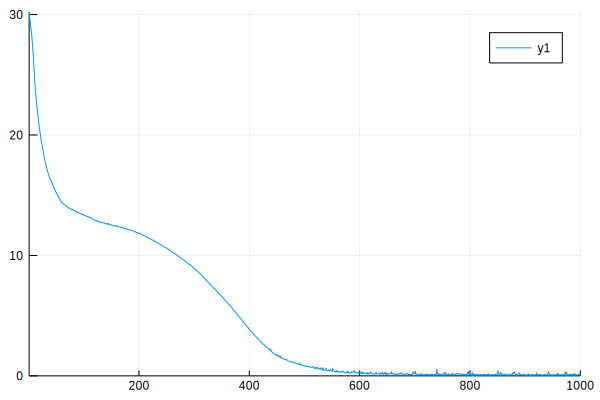

In [68]:
plt = plot(losses)
ylims!(plt, (0, ylims(plt)[2]))

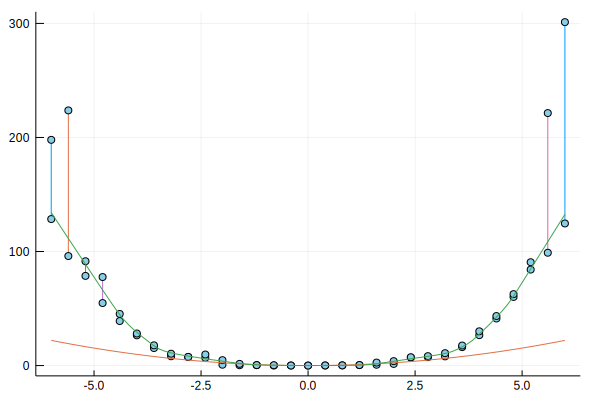

In [69]:
plt = plot(legend=nothing)
for sample in sample_sink.samples
    plot!(plt, [sample.state[11], sample.state[11]], 
            [sample.mip.objective_bound, sample.mip.objective_value],
        marker=:circle,
        markercolor="skyblue"
        )
end

x0 = BoxValkyries.nominal_state(robot)
v_xs = linspace(-6, 6, 101)
plot!(plt, v_xs, function (v_x)
    set_velocity!(x0, findjoint(robot.mechanism, "base_x"), v_x)
    x = Vector(x0)
    (x - lqrsol.x0)' * lqrsol.S * (x - lqrsol.x0)
end
    )

plot!(plt, v_xs, v_x -> Flux.Tracker.data(net([v_x]))[1])
plt